Creating Linnaeus-5 dataset from directory

In [1]:
from google.colab import drive ;
drive.mount('/content/drive') ;

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os ;
import numpy as np ;
from os import listdir ;
import matplotlib.image as mpimg ;
import matplotlib.pyplot as plt ;
from skimage.color import rgb2lab, lab2rgb ;

firstLevel = ['test', 'train'] ;
secondLevel = ['berry', 'bird', 'dog', 'flower', 'other', 'human'] ;
sourceDirectory = '/content/drive/MyDrive/Linnaeus-5/' ;

In [42]:
imageCounter = 0 ;
for i in firstLevel:
  for j in secondLevel[:-1]:
    directory = sourceDirectory + i + '/' + j ;
    for images in os.listdir(directory):
      if(images.endswith(".jpg")):
        imageCounter += 1 ;
print('Total Images: ',  imageCounter) ;
print('Images Per Class: ', imageCounter/5.0) ;

Total Images:  8000
Images Per Class:  1600.0


In [43]:
xtrain = [] ; ytrain = [] ;
xtest = [] ; ytest = [] ;

In [44]:
# I tried to make a subdirectory extractor
for i in firstLevel:
  for j in secondLevel[:-1]:
    directory = sourceDirectory + i + '/' + j ;
    for image in os.listdir(directory):
      if(image.endswith(".jpg")):
        if i == 'test':
          ytest.append(secondLevel.index(j)) ;
          xtest.append(mpimg.imread(directory + '/' + image)) ;
        else:
          ytrain.append(secondLevel.index(j)) ;
          xtrain.append(mpimg.imread(directory + '/' + image)) ;

In [45]:
xtrain = np.array(xtrain, dtype=np.float32)/255 ; ytrain = np.array(ytrain) ;
xtest = np.array(xtest, dtype=np.float32)/255 ; ytest = np.array(ytest) ;
xtrain = np.concatenate((xtrain, xtest[:1500])) ;
ytrain = np.concatenate((ytrain, ytest[:1500])) ;
xtest = xtest[1500:] ;
ytest = ytest[1500:] ;

In [46]:
print('Training Images: ', xtrain.shape, ytrain.shape) ;
print('Testing Images: ', xtest.shape, ytest.shape) ;

Training Images:  (7500, 128, 128, 3) (7500,)
Testing Images:  (500, 128, 128, 3) (500,)


In [47]:
np.save('xtest.npy', xtest) ;
np.save('ytest.npy', ytest) ;
del xtest ;
del ytest ;

In [9]:
import tensorflow as tf ;
from tensorflow.keras import layers, models ;
from tensorflow.keras.utils import plot_model ;

In [10]:
np.random.seed(123) ;
tf.random.set_seed(123) ;
device = tf.test.gpu_device_name() ;
device

'/device:GPU:0'

In [11]:
# Down sampler CNN network
def downCNN(name, filters, kernel_size, batchNormalization = True):
    downsampler = models.Sequential() ;
    downsampler._name = name ;
    downsampler.add(layers.Conv2D(filters, kernel_size, padding = 'same', strides = 2)) ;
    if batchNormalization: downsampler.add(layers.BatchNormalization()) ;
    downsampler.add(layers.LeakyReLU()) ;
    return downsampler ;

In [12]:
def upCNN(name, filters, kernel_size, normalize=True, dropOut = True):
    upsampler = models.Sequential() ;
    upsampler._name = name ;
    upsampler.add(layers.Conv2DTranspose(filters, kernel_size, padding = 'same', strides = 2)) ;
    if normalize: upsampler.add(layers.BatchNormalization()) ;
    if dropOut: upsampler.add(layers.Dropout(0.2)) ;
    upsampler.add(layers.LeakyReLU()) ;
    return upsampler ;

In [13]:
def AutoEncoder():
    # Input grayscale images of dimensions 128*128
    image = layers.Input(shape = [128,128,1]) ;

    # Feed it to an encoder network for downsampling to a latent vector
    d1 = downCNN("Downsampler_1", 128,(3,3),False)(image) ;
    d2 = downCNN("Downsampler_2", 128,(3,3),True)(d1) ;
    d3 = downCNN("Downsampler_3", 256,(3,3),True)(d2) ;
    d4 = downCNN("Downsampler_4", 512,(3,3),True)(d3) ;
    d5 = downCNN("Downsampler_5", 512,(3,3),True)(d4) ;

    # Decode the latent vector to upscale into large image matrix
    u1 = upCNN("Upsampler_1", 512,(3,3),True,False)(d5) ;
    u1 = layers.concatenate([u1,d4]) ;
    u2 = upCNN("Upsampler_2", 256,(3,3),True,False)(u1) ;
    u2 = layers.concatenate([u2,d3]) ;
    u3 = upCNN("Upsampler_3", 128,(3,3),True,True)(u2) ;
    u3 = layers.concatenate([u3,d2]) ;
    u4 = upCNN("Upsampler_4", 128,(3,3),True,False)(u3) ;
    u4 = layers.concatenate([u4,d1]) ;
    u5 = upCNN("Upsampler_5", 3,(3,3),False,False)(u4) ;
    u5 = layers.concatenate([u5,image]) ;

    # Generate colored images with final convolution
    output = layers.Conv2D(3, (2,2), strides = 1, padding = 'same')(u5) ;
    return models.Model(inputs=image, outputs=output) ;

In [14]:
colorizer = AutoEncoder() ;
plot_model(colorizer, to_file='colorizerUsingAutoEncoder128*128.png', show_shapes=True) ;
print(colorizer.summary()) ;

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 Downsampler_1 (Sequential)  (None, 64, 64, 128)          1280      ['input_1[0][0]']             
                                                                                                  
 Downsampler_2 (Sequential)  (None, 32, 32, 128)          148096    ['Downsampler_1[0][0]']       
                                                                                                  
 Downsampler_3 (Sequential)  (None, 16, 16, 256)          296192    ['Downsampler_2[0][0]']       
                                                                                              

Dataset Analysis & Preprocessing

In [15]:
def showImage(data, index, label=None):
  plt.figure(figsize=(0.5, 0.5)) ;
  plt.imshow(data[index]) ;
  if label != None:
    plt.xlabel(labels[label[index]]) ;

In [16]:
import cv2 ;
def random_color_augmentation(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) ;
    # Randomly adjust the hue, saturation, and value of the image.
    hue_delta = np.random.uniform(-10, 10) ;
    saturation_delta = np.random.uniform(0.5, 1.5) ;
    value_delta = np.random.uniform(0.5, 1.5) ;
    # Apply the random deltas to the image
    hue = np.add(image[:, :, 0], hue_delta) ;
    saturation = np.multiply(image[:, :, 1], saturation_delta) ;
    value = np.multiply(image[:, :, 2], value_delta) ;
    # Clip the adjusted values to the 0-1 range
    hue = np.clip(hue, 0, 180) ;
    saturation = np.clip(saturation, 0, 1) ;
    value = np.clip(value, 0, 1) ;
    # Convert the adjusted channels back to RGB color space
    augmented_image = cv2.cvtColor(np.stack([hue, saturation, value], axis=2), cv2.COLOR_HSV2RGB) ;
    return augmented_image ;

In [17]:
augmentedImages = np.zeros(shape=(xtrain.shape[0], 128,128,3), dtype=np.float32) ;
for i in range(xtrain.shape[0]):
  augmentedImages[i] = random_color_augmentation(xtrain[i]) ;
augmentedImages.shape

(7500, 128, 128, 3)

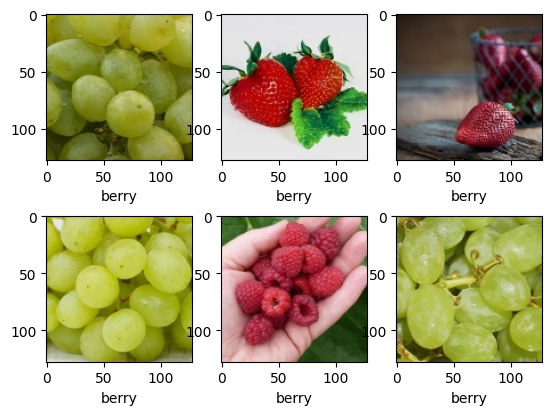

In [18]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrain[i]) ;
    axes[int(i/3)][int(i%3)].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

<ipython-input-19-c46459265be9>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,2, figsize=(6,1)) ;


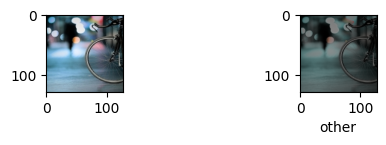

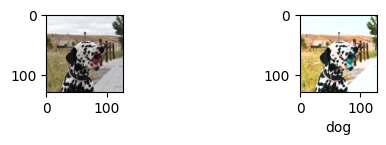

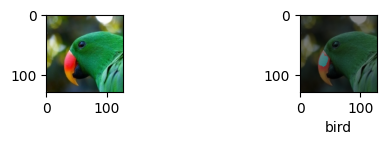

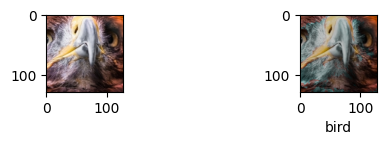

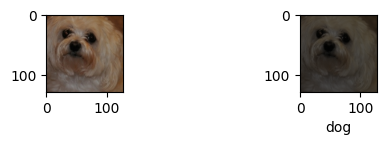

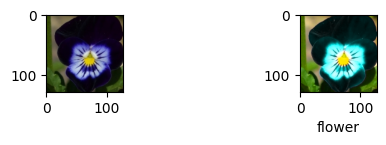

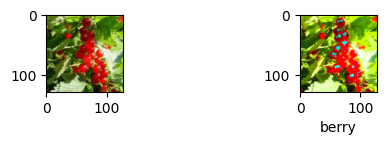

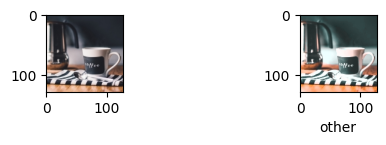

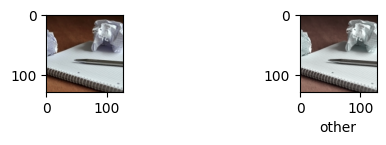

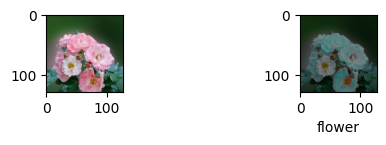

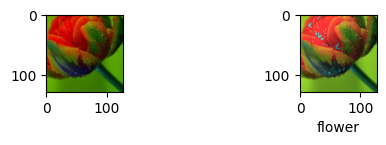

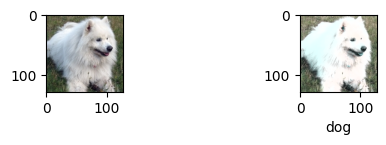

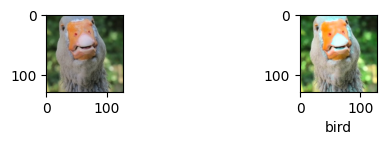

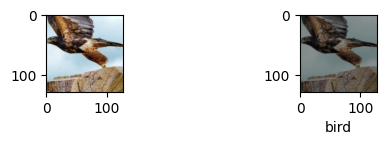

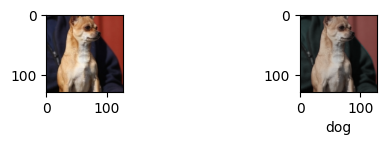

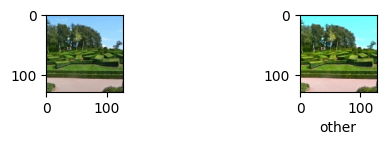

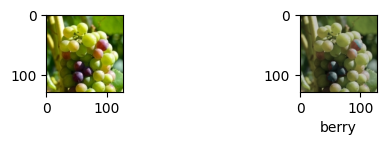

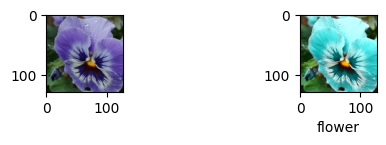

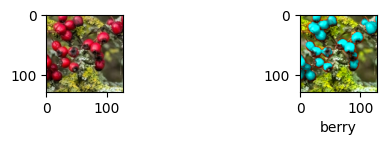

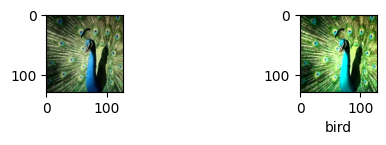

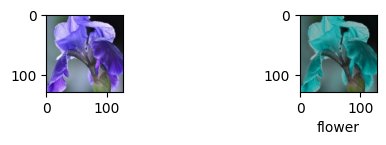

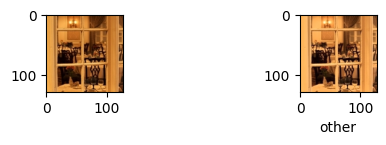

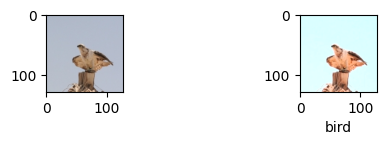

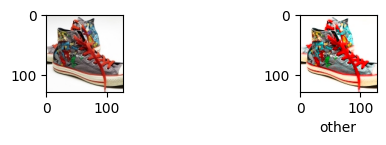

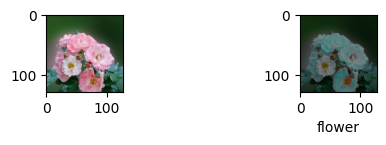

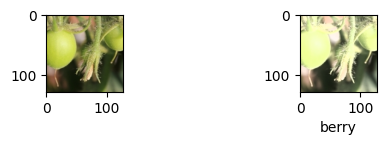

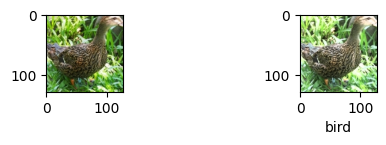

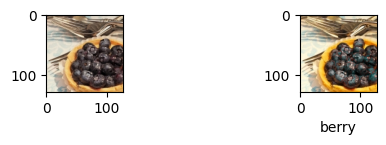

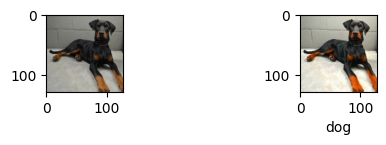

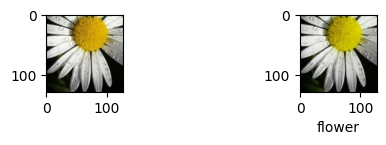

In [19]:
randomIndex = np.random.randint(low=0, high=7000, size=30) ;
for i in randomIndex:
  figure, axes = plt.subplots(1,2, figsize=(6,1)) ;
  axes[0].imshow(xtrain[i]) ;
  axes[1].imshow(augmentedImages[i]) ;
  axes[1].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

In [20]:
xtrain = np.concatenate((xtrain, augmentedImages[:3000]), axis=0) ;
del augmentedImages ;
print(xtrain.shape) ;

(10500, 128, 128, 3)


In [21]:
def rgb2gray(rgb):
    value = np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) ;
    return value ;

In [22]:
xtrainG = np.zeros((xtrain.shape[0],128,128)).astype(np.float32) ;
for i in range(xtrain.shape[0]):
  xtrainG[i] = rgb2gray(xtrain[i]) ;

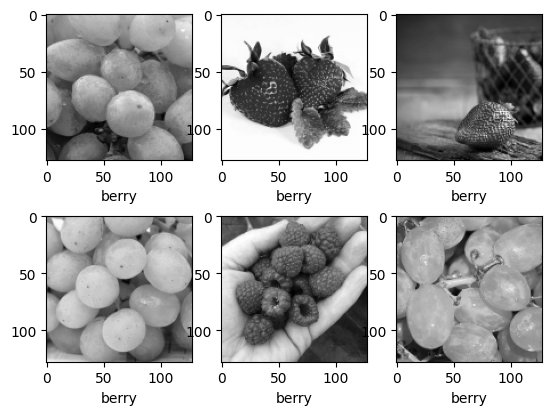

In [23]:
figure, axes = plt.subplots(2, 3) ;
for i in range(6):
    axes[int(i/3)][int(i%3)].imshow(xtrainG[i], cmap='gray') ;
    axes[int(i/3)][int(i%3)].set_xlabel(secondLevel[ytrain[i]]) ;
plt.show() ;

Model Training & Evaluation

In [24]:
colorizer.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error', metrics = ['accuracy']) ;
colorizer

In [25]:
# !!! WARNING: This optimizes CPU performance - DON'T USE THIS WHEN GPU IS ENABLED !!! (Learnt the hard way!)
# tf.config.run_functions_eagerly(True) ; #  IT ENABLES CONVOLUTION LAYER TO FUNCTION EARLY CAUSING ISSUES IN TENSORS IF GPU IS USED
# tf.data.experimental.enable_debug_mode() ; # IT DISABLES PARALLELISM AND FORCES SEQUENTIAL OPERATION

In [26]:
history = colorizer.fit(xtrainG, xtrain, epochs = 200, batch_size = 50, validation_split=0.05, shuffle=True, verbose = True) ;

Epoch 1/200
200/200 [==============================] - 62s 203ms/step - loss: 0.0935 - accuracy: 0.4115 - val_loss: 0.0880 - val_accuracy: 0.4241
Epoch 2/200
200/200 [==============================] - 40s 201ms/step - loss: 0.0800 - accuracy: 0.4327 - val_loss: 0.0680 - val_accuracy: 0.4090
Epoch 3/200
200/200 [==============================] - 41s 203ms/step - loss: 0.0776 - accuracy: 0.4530 - val_loss: 0.1497 - val_accuracy: 0.2365
Epoch 4/200
200/200 [==============================] - 41s 205ms/step - loss: 0.0763 - accuracy: 0.4666 - val_loss: 0.0585 - val_accuracy: 0.4628
Epoch 5/200
200/200 [==============================] - 41s 203ms/step - loss: 0.0757 - accuracy: 0.4692 - val_loss: 0.0574 - val_accuracy: 0.3617
Epoch 6/200
200/200 [==============================] - 41s 203ms/step - loss: 0.0749 - accuracy: 0.4768 - val_loss: 0.0673 - val_accuracy: 0.4700
Epoch 7/200
200/200 [==============================] - 41s 203ms/step - loss: 0.0748 - accuracy: 0.4806 - val_loss: 0.0532 -

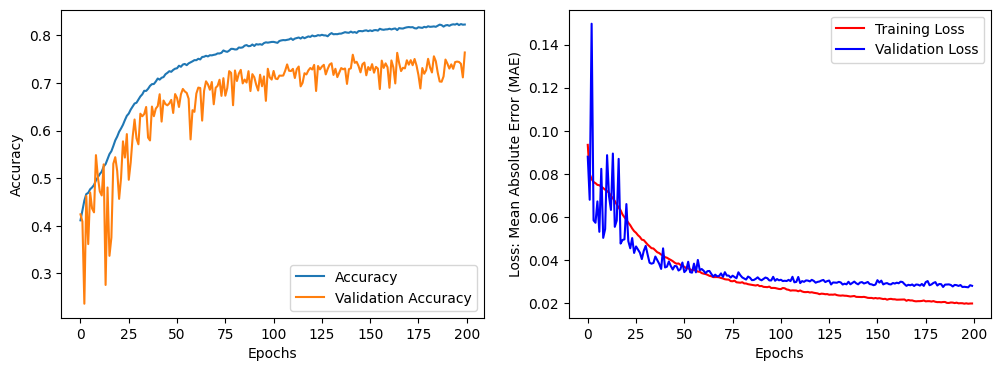

In [27]:
figure, axes = plt.subplots(1,2, figsize=(12,4)) ;
axes[0].plot(history.history['accuracy'], label='Accuracy') ;
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy') ;
axes[0].set_xlabel('Epochs') ;
axes[0].set_ylabel('Accuracy') ;
axes[0].legend() ;
axes[1].plot(history.history['loss'], color='red', label='Training Loss') ;
axes[1].plot(history.history['val_loss'], color='blue', label='Validation Loss') ;
axes[1].set_xlabel('Epochs') ;
axes[1].set_ylabel('Loss: Mean Absolute Error (MAE)') ;
axes[1].legend() ;
plt.show() ;

In [28]:
!pip install pyyaml h5py
colorizer.save('autoEncoderCNN_colorizer_linnaeus5.h5') ;
colorizer.save('autoEncoderCNN_colorizer_linnaeus5.keras') ;

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
del xtrain ;
del ytrain ;
xtest = np.load("xtest.npy") ;
ytest = np.load("ytest.npy") ;

In [49]:
xtestG = np.zeros((xtest.shape[0],128,128)).astype(np.float32) ;
for i in range(xtest.shape[0]):
  xtestG[i] = rgb2gray(xtest[i]) ;

In [50]:
colorizer.evaluate(xtestG, xtest) ;

16/16 [==============================] - 3s 99ms/step - loss: 0.0765 - accuracy: 0.4617


Model Prediction & Output Overview

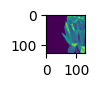

In [51]:
showImage(xtestG, 0) ;

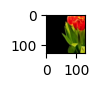

In [52]:
showImage(xtest, 0) ;

In [53]:
coloredOutput = colorizer.predict(xtestG[0].reshape(1,128,128,1)) ;

1/1 [==============================] - 1s 960ms/step


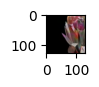

In [54]:
coloredOutput = coloredOutput.astype(np.float32) ;
showImage(coloredOutput, 0) ;

1/1 [==============================] - 0s 18ms/step


<ipython-input-59-f7307eb923e5>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;


1/1 [==============================] - 0s 25ms/step


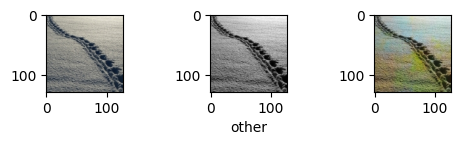

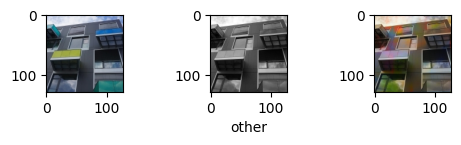

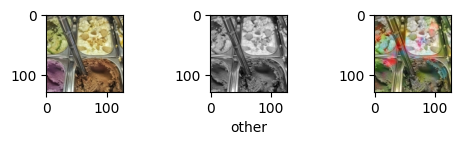

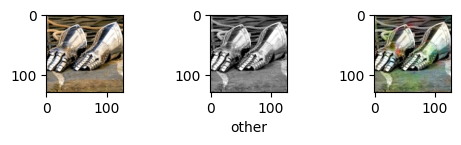

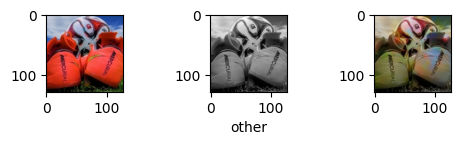

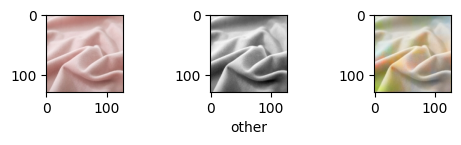

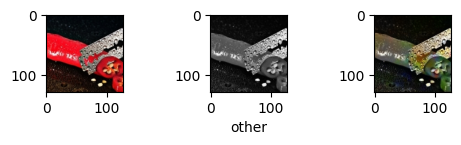

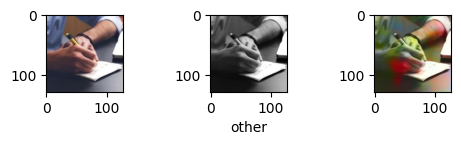

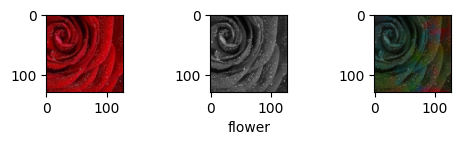

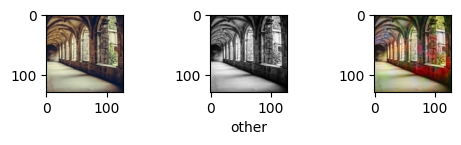

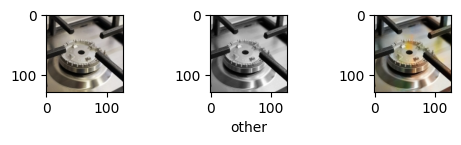

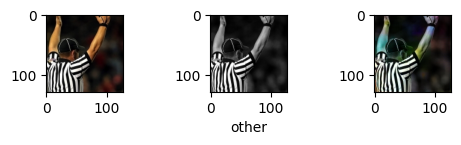

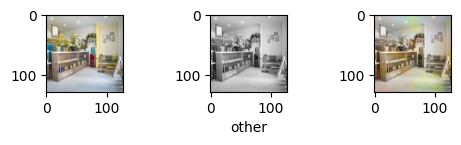

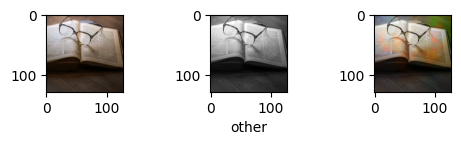

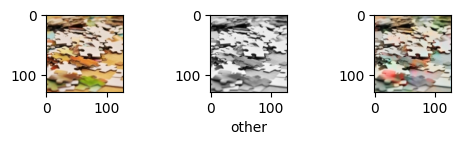

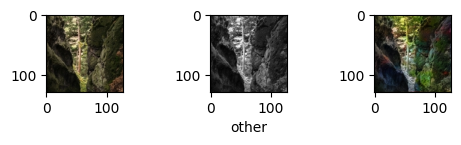

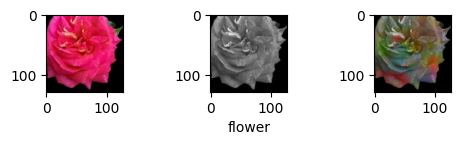

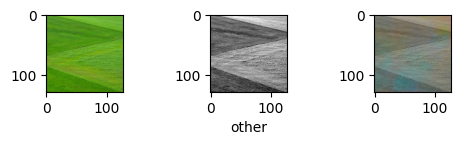

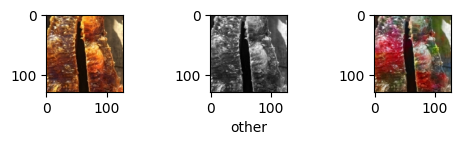

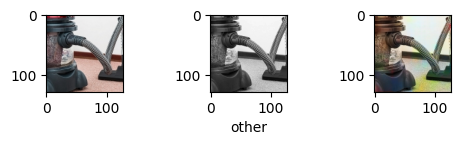

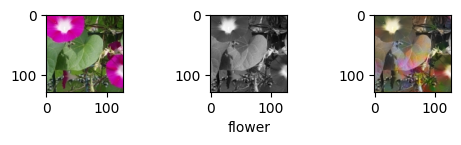

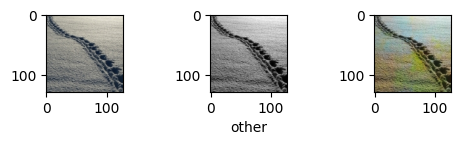

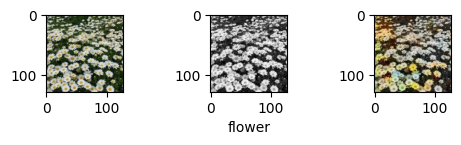

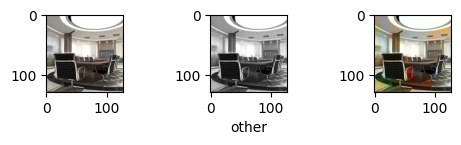

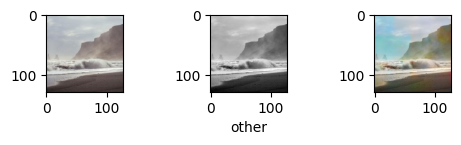

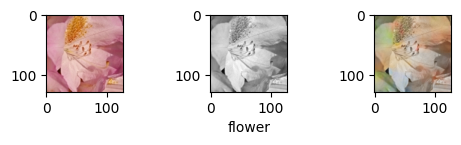

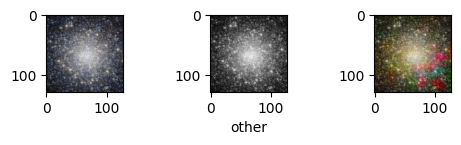

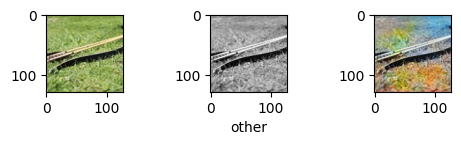

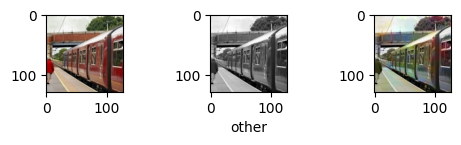

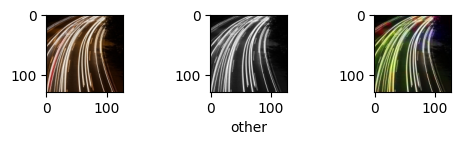

In [59]:
randomIndex = np.random.randint(low=0, high=500, size=30) ;
for i in randomIndex:
  output = colorizer.predict(xtestG[i].reshape(1,128,128,1)) ;
  output = np.clip(output, 0.0, 1.0).astype(np.float32) ;
  figure, axes = plt.subplots(1,3, figsize=(6,1)) ;
  axes[0].imshow(xtest[i]) ;
  axes[1].imshow(xtestG[i], cmap='gray') ;
  axes[1].set_xlabel(secondLevel[ytest[i]]) ;
  axes[2].imshow(output[0]) ;
plt.show() ;